In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Initialize the data generator with augmentation options
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the images to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    r'dataset\train',
    target_size=(224, 224),  # Depending on the model architecture
    batch_size=32,
    class_mode='categorical',
    subset="training"
)
validation_generator = datagen.flow_from_directory(
    r'dataset\train',
    target_size=(224, 224),  # Depending on the model architecture
    batch_size=32,
    class_mode='categorical',
    subset="validation"
)
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    r'dataset\test',
    target_size=(224, 224),  # Depending on the model architecture
    batch_size=32,
    class_mode='categorical'
)

Found 1784 images belonging to 2 classes.
Found 445 images belonging to 2 classes.
Found 1496 images belonging to 2 classes.


In [2]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import numpy as np 

# Load the base model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)

def extract_features(generator, sample_count):
    # Assuming the model's output is 1024-dimensional features
    # Initialize arrays to hold the extracted features and labels.
    # Note: We use None for flexible sizing in the features' first dimension.
    features = np.zeros((0, 1024))  # Adjust 1024 if a different model output size is expected
    labels = np.zeros((0,))
    
    # Keep track of the number of samples processed
    processed_samples = 0
    
    for inputs_batch, labels_batch in generator:
        # Ensure not to process more than the sample_count
        if processed_samples < sample_count:
            # Predict features for the current batch of images
            features_batch = model.predict(inputs_batch)
            actual_batch_size = features_batch.shape[0]
            
            # Update the total number of processed samples
            processed_samples += actual_batch_size
            
            # Append the predicted features and the true labels to their respective arrays
            features = np.append(features, features_batch, axis=0)
            labels = np.append(labels, np.argmax(labels_batch, axis=1), axis=0)
            
            # If we've processed enough samples, break from the loop
            if processed_samples >= sample_count:
                break
        else:
            break
    
    # If we've processed more samples than needed, truncate the arrays
    if processed_samples > sample_count:
        features = features[:sample_count]
        labels = labels[:sample_count]
    
    return features, labels

train_features, train_labels = extract_features(train_generator, 200) # Adjust 200 to actual size
validation_features, validation_labels = extract_features(validation_generator, 50) # Adjust 50 to actual size


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


In [3]:
model.save("feature_extractor.h5")

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create and train the Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_features, train_labels)

# Predict on the validation set
validation_predictions = rf.predict(validation_features)

# Evaluate the model
print("Validation Accuracy: ", accuracy_score(validation_labels, validation_predictions))
print("Classification Report:\n", classification_report(validation_labels, validation_predictions))


Validation Accuracy:  0.94
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95        29
         1.0       0.95      0.90      0.93        21

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



In [5]:
confusion_matrix(validation_labels, validation_predictions)

array([[28,  1],
       [ 2, 19]], dtype=int64)

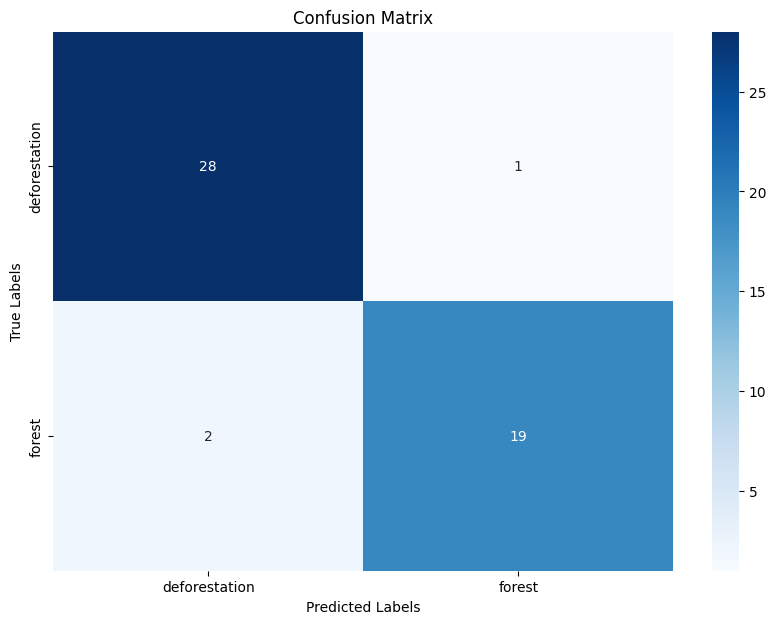

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(validation_labels, validation_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['deforestation', 'forest'], 
            yticklabels=['deforestation', 'forest'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [6]:
import joblib
joblib.dump(rf, 'rf_model.pkl')

['rf_model.pkl']

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load the feature extractor model (MobileNet-based model)
feature_extractor = load_model('feature_extractor.h5')

# Load the trained Random Forest model
rf_model = joblib.load('rf_model.pkl')

# Define the class labels
class_labels = ['deforestation', 'forest']

# Function to preprocess the input image
def preprocess_image(img_path):
    # Load the image with target size as (224, 224) to match MobileNet input size
    img = image.load_img(img_path, target_size=(224, 224))
    # Convert the image to an array
    img_array = image.img_to_array(img)
    # Rescale the image by dividing by 255 (normalization)
    img_array = img_array / 255.0
    # Add a batch dimension since the model expects batches of images
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to predict the class of a single image
def predict_single_image(img_path):
    # Preprocess the input image
    preprocessed_image = preprocess_image(img_path)
    
    # Extract features using the MobileNet-based feature extractor
    features = feature_extractor.predict(preprocessed_image)
    
    # Predict the class using the Random Forest classifier
    predicted_class_index = rf_model.predict(features)[0]
    
    # Convert the predicted class index to an integer (since it's a numpy.float64)
    predicted_class_index = int(predicted_class_index)
    
    # Convert the class index to the class label
    predicted_class_label = class_labels[predicted_class_index]
    
    return predicted_class_label

# Test with an example image
image_path = r'dataset\test\deforestation\IMG_0_203.jpg'  # Replace with your image path
predicted_class = predict_single_image(image_path)
print(f'The predicted class for the input image is: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
The predicted class for the input image is: deforestation
